### import libraries

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
from math import pi
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
%matplotlib inline

### import weather station data

In [2]:
# load list of weather stations
station_file = 'cloud-data/digitalrnd-projects-ireland/Vaccine/Research/Magellan/users/XLO/test/temp/ghcnd-stations_cleaned.tsv'
df_stations = pd.read_csv(station_file,
                          sep='\t',
                          header=None,
                          names=['id_station', 'lat', 'long', 'unk', 'state'],
                         )
df_stations.drop(columns=['unk'], inplace=True)
#df_stations.head(10)

In [3]:
# create geometry points
gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.long, df_stations.lat), crs="EPSG:4269")
gdf_stations

id_station      lat      long state                     geometry
0      US009052008  43.7333  -96.6333    SD   POINT (-96.63330 43.73330)
1      US10RMHS145  40.5268 -105.1113    CO  POINT (-105.11130 40.52680)
2      US10adam001  40.5680  -98.5069    NE   POINT (-98.50690 40.56800)
3      US10adam002  40.5093  -98.5493    NE   POINT (-98.54930 40.50930)
4      US10adam003  40.4663  -98.6537    NE   POINT (-98.65370 40.46630)
...            ...      ...       ...   ...                          ...
72527  RQW00011618  18.4667  -66.1167    PR   POINT (-66.11670 18.46670)
72528  RQW00011630  18.2553  -65.6411    PR   POINT (-65.64110 18.25530)
72529  RQW00011631  18.4667  -66.1000    PR   POINT (-66.10000 18.46670)
72530  RQW00011637  17.9667  -66.4000    PR   POINT (-66.40000 17.96670)
72531  RQW00011641  18.4325  -66.0106    PR   POINT (-66.01060 18.43250)

[72532 rows x 5 columns]

### import US forests data

In [4]:
# function to convert distance in km or feet to degrees
def dist2deg(dist, unit):
    if unit == 'km': earth_radius = 6371
    elif unit == 'feet': earth_radius = 20902231.64
    
    deg = dist * 360 / (2*pi*earth_radius)
    
    return deg

In [5]:
# load national forests table
gdf_forest = gpd.read_file('cloud-data/digitalrnd-projects-ireland/Vaccine/Research/Magellan/users/XLO/test/temp/S_USA.ProclaimedForest/S_USA.ProclaimedForest.shp')
gdf_forest.head()

ERROR 1: PROJ: proj_create_from_database: Open of /cloud-home/XLOUIS/.magellan/conda/envs/geo/share/proj failed


PROCLAIMED                    FORESTNAME    GIS_ACRES  SHAPE_AREA  \
0  295435010328     Allegheny National Forest   740686.211    0.323984   
1  295380010328       Angeles National Forest   695598.432    0.276018   
2  295458010328      Angelina National Forest   398093.002    0.152499   
3  295372010328        Apache National Forest  1869703.247    0.736196   
4  295400010328  Apalachicola National Forest   633591.300    0.240186   

   SHAPE_LEN                                           geometry  
0   3.965097  MULTIPOLYGON (((-79.08263 41.82929, -79.08169 ...  
1   4.674530  MULTIPOLYGON (((-117.99249 34.47388, -117.9924...  
2   3.691482  MULTIPOLYGON (((-94.13486 31.01703, -94.13486 ...  
3   6.526785  POLYGON ((-108.43800 34.25970, -108.43773 34.2...  
4   3.367179  MULTIPOLYGON (((-84.38794 30.44066, -84.38682 ...

In [6]:
# extension of the original forest shapes with buffer
distance = '5 km'
dist = int(distance.split()[0])
unit = distance.split()[1]
buf_file_path = Path(f'cloud-data/digitalrnd-projects-ireland/Vaccine/Research/Magellan/users/XLO/test/temp/S_USA.ProclaimedForest/us_forests_ext_d{dist}.shp')

if buf_file_path.is_file():
    print('file already exists')
    gdf_forest_ext = gpd.read_file(buf_file_path)
    print('gdf ok')
else:
    buffer_size = dist2deg(dist, unit)
    gdf_forest_ext = gdf_forest.copy()
    gdf_forest_ext['geometry'] = gdf_forest.buffer(buffer_size)

    # saving the buffers to save time and resources
    gdf_forest_ext.to_file(buf_file_path)
    print('file ok')

file already exists
gdf ok


### join weather stations and US forests

In [7]:
# original shape of forests
joined_gdf = gpd.sjoin(gdf_stations, gdf_forest[['PROCLAIMED', 'geometry']], how='left')
#joined_gdf.loc[joined_gdf['PROCLAIMED'].notnull()].drop('index_right', axis=1)

In [8]:
# extended foret shapes
joined_gdf_ext = gpd.sjoin(gdf_stations, gdf_forest_ext[['PROCLAIMED', 'geometry']], how='left')
joined_gdf_ext.loc[joined_gdf_ext['PROCLAIMED'].notnull()].drop('index_right', axis=1)

id_station      lat      long state                     geometry  \
48     US10blai003  41.7609 -100.2353    NE  POINT (-100.23530 41.76090)   
49     US10blai004  41.9043 -100.2657    NE  POINT (-100.26570 41.90430)   
52     US10blai008  41.8030 -100.2225    NE  POINT (-100.22250 41.80300)   
54     US10blai011  41.8838 -100.1740    NE  POINT (-100.17400 41.88380)   
202    US10cher024  42.8200 -101.2825    NE  POINT (-101.28250 42.82000)   
...            ...      ...       ...   ...                          ...   
72490  RQC00668144  18.2425  -65.7850    PR   POINT (-65.78500 18.24250)   
72491  RQC00668155  18.2833  -65.7833    PR   POINT (-65.78330 18.28330)   
72493  RQC00668245  18.3333  -65.8167    PR   POINT (-65.81670 18.33330)   
72502  RQC00668745  18.2167  -65.7333    PR   POINT (-65.73330 18.21670)   
72512  RQC00669116  18.3578  -65.8283    PR   POINT (-65.82830 18.35780)   

         PROCLAIMED  
48     295470010328  
49     295470010328  
52     295470010328  
54     295470010328  
202    295433010328  
...             ...  
72490  295434010328  
72491  295434010328  
72493  295434010328  
72502  295434010328  
72512  295434010328  

[9203 rows x 6 columns]

In [9]:
# count nb of weather stations by US forest
nb_stations = joined_gdf['PROCLAIMED'].value_counts().reset_index()
#nb_stations

In [10]:
nb_stations_ext = joined_gdf_ext['PROCLAIMED'].value_counts().reset_index()
#nb_stations_ext

In [11]:
print(nb_stations_ext['count'].sum(), 'stations au total')
print(nb_stations_ext['count'].max(), 'stations maxi')
print(nb_stations_ext['count'].min(), 'stations mini')
print(nb_stations_ext['count'].median(), 'stations par forêt')

9203 stations au total
279 stations maxi
2 stations mini
43.5 stations par forêt


### add count of weather stations by US forest

In [12]:
gdf_forest = pd.merge(gdf_forest, nb_stations, how='left', on='PROCLAIMED')
gdf_forest = gdf_forest.rename(columns={'count':'nb_stations'})
gdf_forest['nb_stations'] = gdf_forest['nb_stations'].replace(np.nan, 0)
gdf_forest['nb_stations'] = gdf_forest['nb_stations'].astype('int')
#gdf_forest

In [13]:
gdf_forest = pd.merge(gdf_forest, nb_stations_ext, how='left', on='PROCLAIMED')
gdf_forest = gdf_forest.rename(columns={'count':'nb_stations_ext'})
gdf_forest['nb_stations_ext'] = gdf_forest['nb_stations_ext'].replace(np.nan, 0)
gdf_forest['nb_stations_ext'] = gdf_forest['nb_stations_ext'].astype('int')
gdf_forest

PROCLAIMED                           FORESTNAME    GIS_ACRES  \
0    295435010328            Allegheny National Forest   740686.211   
1    295380010328              Angeles National Forest   695598.432   
2    295458010328             Angelina National Forest   398093.002   
3    295372010328               Apache National Forest  1869703.247   
4    295400010328         Apalachicola National Forest   633591.300   
..            ...                                  ...          ...   
149  295401010328          White River National Forest  2482446.167   
150  109214010328              Whitman National Forest  1311082.638   
151  295436010328           Willamette National Forest  1794216.105   
152  295365010328  William B. Bankhead National Forest   349259.985   
153  262611010328               Winema National Forest  1094251.130   

     SHAPE_AREA  SHAPE_LEN                                           geometry  \
0      0.323984   3.965097  MULTIPOLYGON (((-79.08263 41.82929, -79.08169 ...   
1      0.276018   4.674530  MULTIPOLYGON (((-117.99249 34.47388, -117.9924...   
2      0.152499   3.691482  MULTIPOLYGON (((-94.13486 31.01703, -94.13486 ...   
3      0.736196   6.526785  POLYGON ((-108.43800 34.25970, -108.43773 34.2...   
4      0.240186   3.367179  MULTIPOLYGON (((-84.38794 30.44066, -84.38682 ...   
..          ...        ...                                                ...   
149    1.052907  13.329421  MULTIPOLYGON (((-106.25540 39.91386, -106.2547...   
150    0.605272  18.320346  MULTIPOLYGON (((-118.35084 45.38872, -118.3507...   
151    0.816252   8.953350  MULTIPOLYGON (((-122.25418 44.89989, -122.2539...   
152    0.138292   2.451515  MULTIPOLYGON (((-87.32875 34.42494, -87.32878 ...   
153    0.487341  14.553148  MULTIPOLYGON (((-121.96111 42.67550, -121.9635...   

     nb_stations  nb_stations_ext  
0             14               33  
1             45              100  
2              9               13  
3             34               40  
4              9               22  
..           ...              ...  
149           97              153  
150           23               41  
151           42               54  
152            7               13  
153           16               28  

[154 rows x 8 columns]

In [14]:
# forests without any station
gdf_forest.loc[gdf_forest['nb_stations'] == 0]

PROCLAIMED                          FORESTNAME   GIS_ACRES  SHAPE_AREA  \
37   295416010328               Delta National Forest  120734.330    0.047012   
42   295424010328        Finger Lakes National Forest   16811.219    0.007453   
108  295433010328  Samuel R. McKelvie National Forest  116496.427    0.051804   
134  295415010328           Tombigbee National Forest  119662.575    0.046991   
138  295368010328            Tuskegee National Forest   15649.277    0.006075   

     SHAPE_LEN                                           geometry  \
37    1.452577  POLYGON ((-90.77597 32.88585, -90.77586 32.885...   
42    1.969073  MULTIPOLYGON (((-76.78327 42.57657, -76.78303 ...   
108   1.220080  POLYGON ((-100.88016 42.78056, -100.88026 42.7...   
134   1.803362  MULTIPOLYGON (((-89.08839 33.32965, -89.08832 ...   
138   0.506328  POLYGON ((-85.55816 32.49722, -85.55814 32.496...   

     nb_stations  nb_stations_ext  
37             0                2  
42             0                9  
108            0                2  
134            0                5  
138            0                3

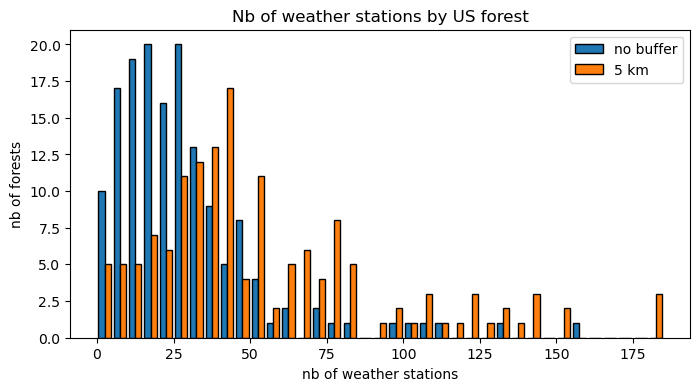

In [15]:
stats=[gdf_forest['nb_stations'],gdf_forest['nb_stations_ext']]
plt.figure(figsize=(8,4))
#plt.hist(gdf_forest['nb_stations'], bins=range(0,170,10), edgecolor='k')
plt.hist(stats, bins=range(0,190,5), edgecolor='k', label=['no buffer', '5 km'])
plt.title('Nb of weather stations by US forest')
plt.xlabel('nb of weather stations')
plt.ylabel('nb of forests')
plt.legend();

Allegheny National Forest


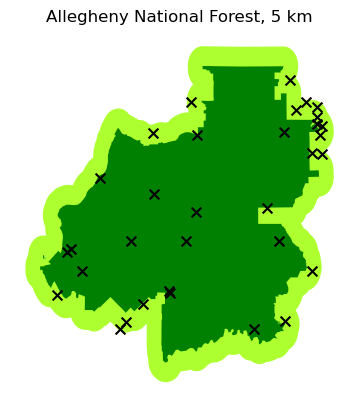

Angeles National Forest


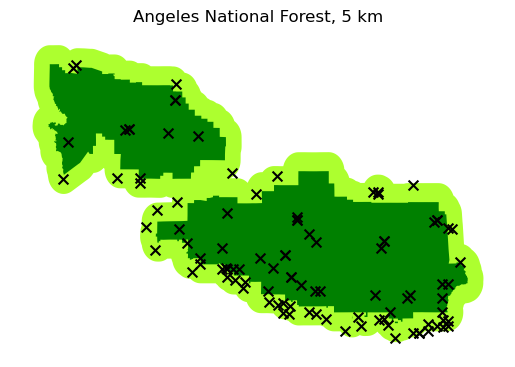

Angelina National Forest


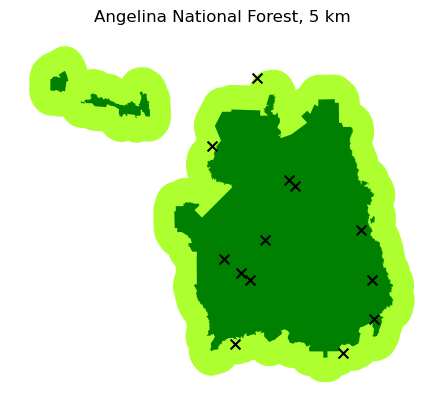

Apache National Forest


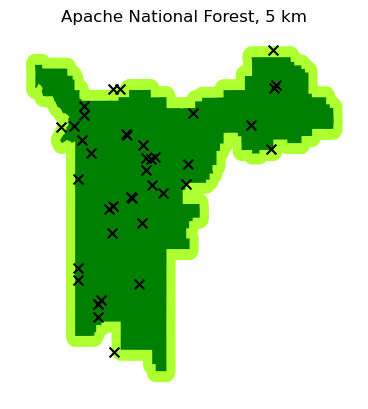

Apalachicola National Forest


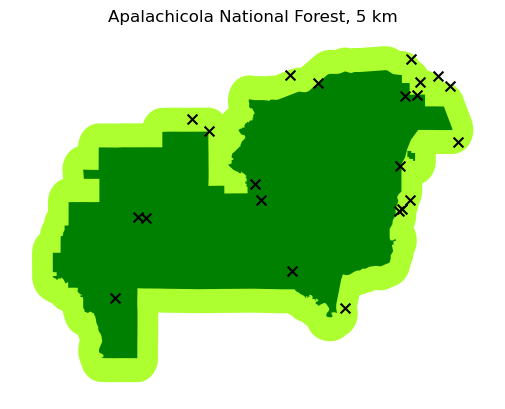

Arapaho National Forest


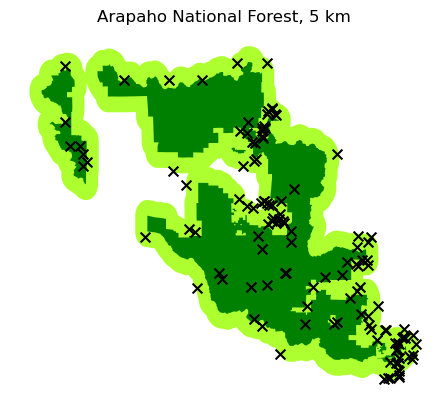

Ashley National Forest


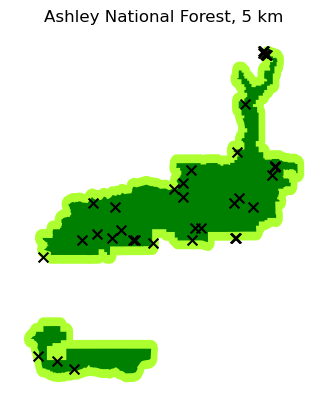

Beaverhead National Forest


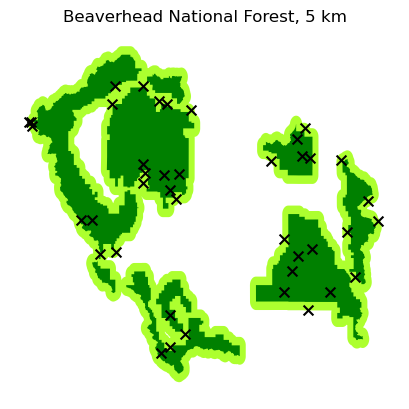

Bienville National Forest


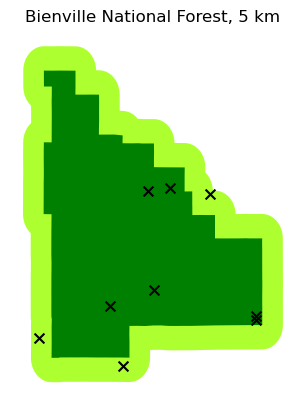

Bighorn National Forest


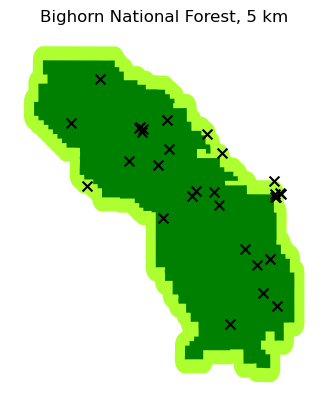

Bitterroot National Forest


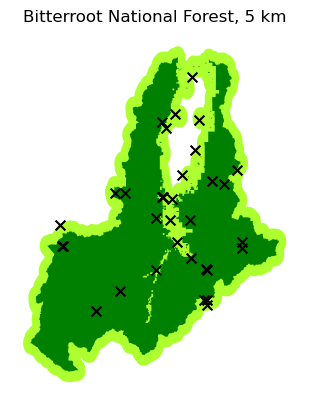

Black Hills National Forest


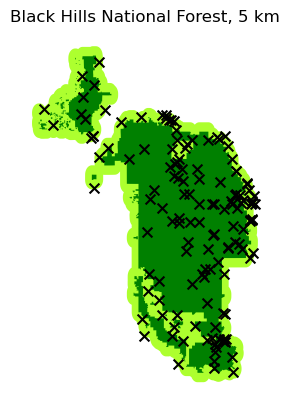

Boise National Forest


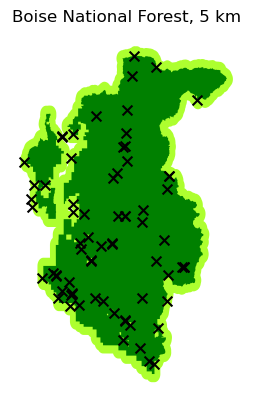

Bridger National Forest


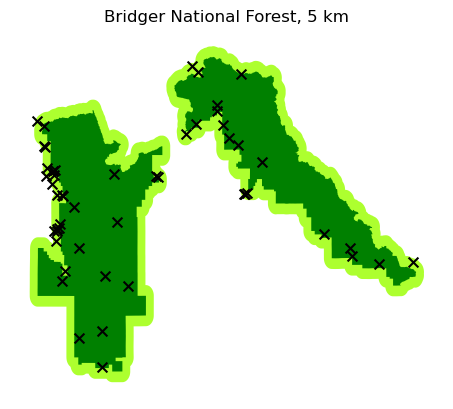

Cache National Forest


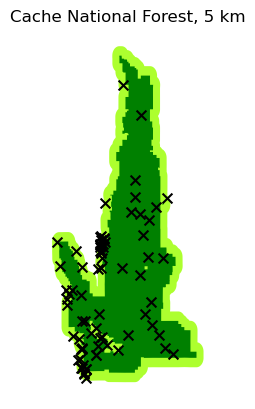

Caribou National Forest


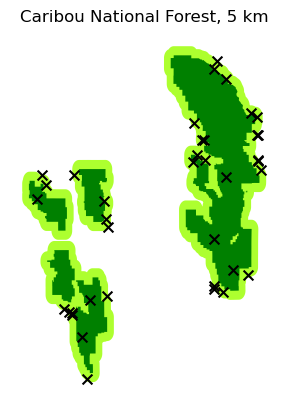

Carson National Forest


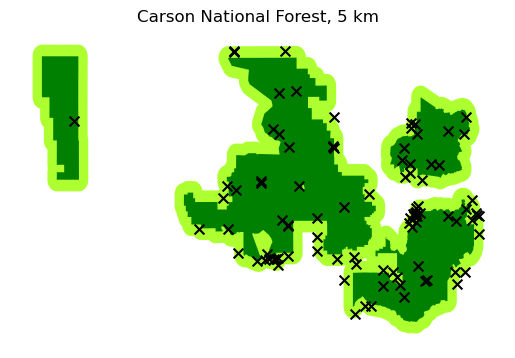

Challis National Forest


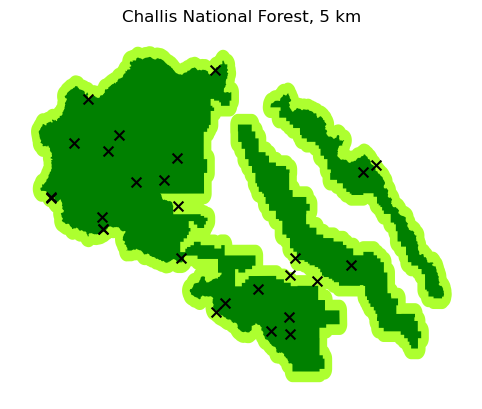

Chattahoochee National Forest


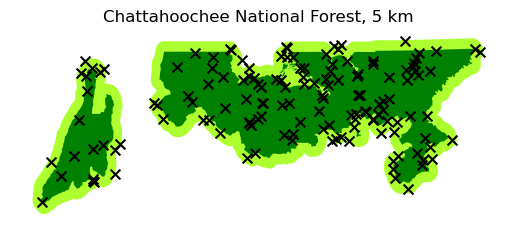

Chequamegon National Forest


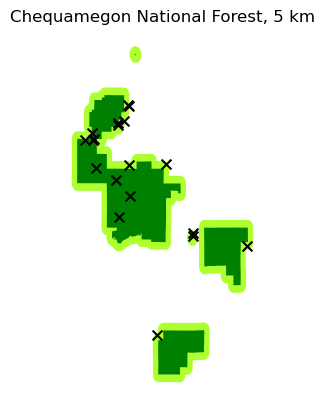

Cherokee National Forest


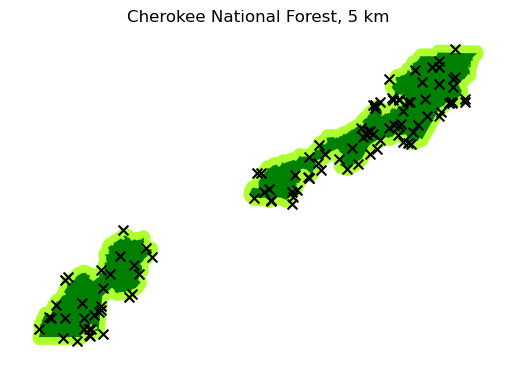

Chippewa National Forest


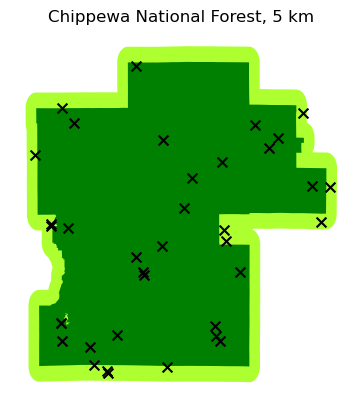

Chugach National Forest


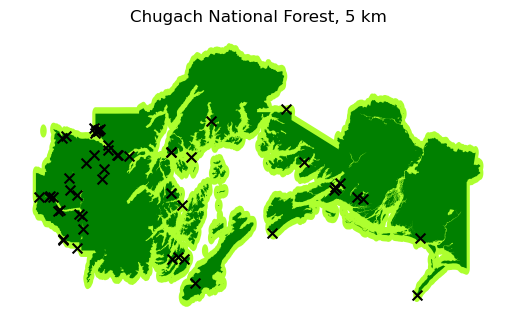

Cibola National Forest


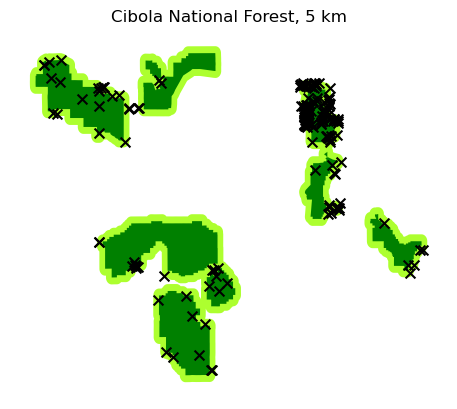

Clearwater National Forest


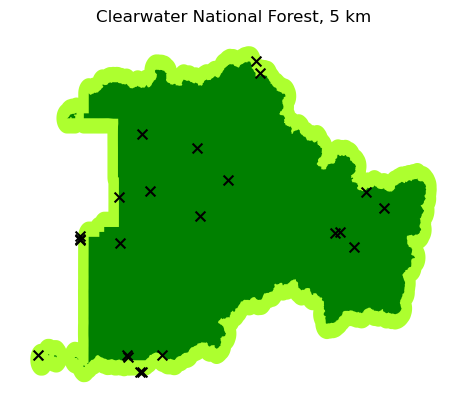

Cleveland National Forest


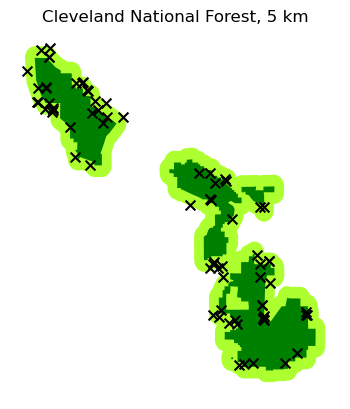

Coconino National Forest


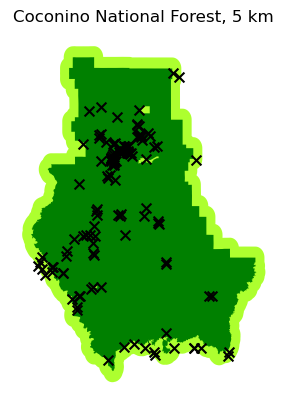

Coeur d'Alene National Forest


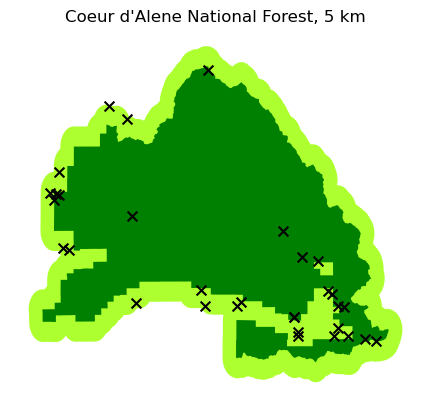

Colville National Forest


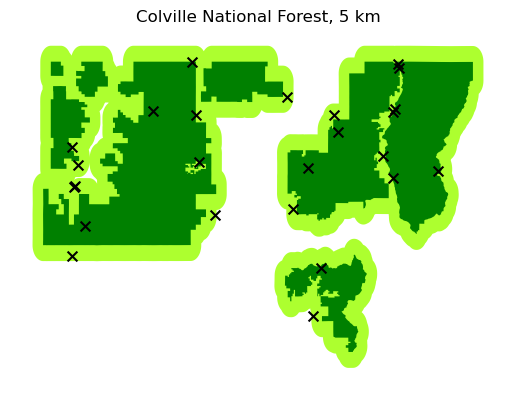

Conecuh National Forest


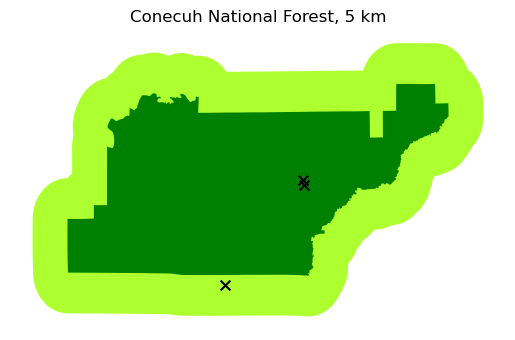

Coronado National Forest


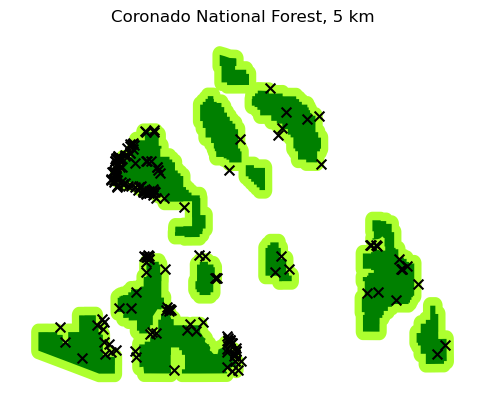

Croatan National Forest


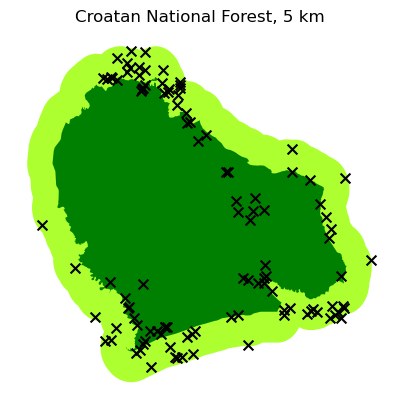

Custer National Forest


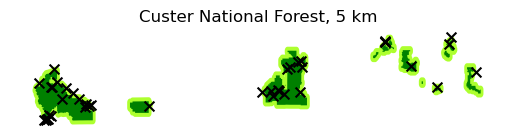

Daniel Boone National Forest


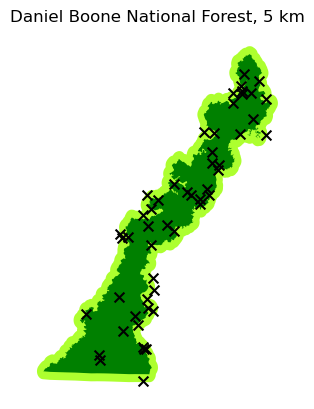

Davy Crockett National Forest


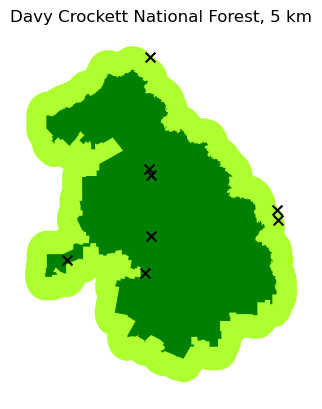

De Soto National Forest


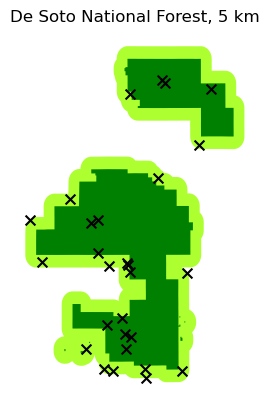

Deerlodge National Forest


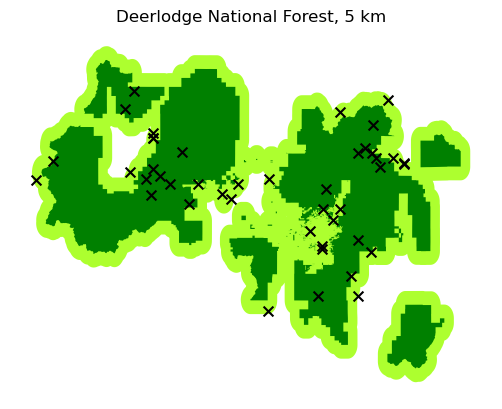

Delta National Forest


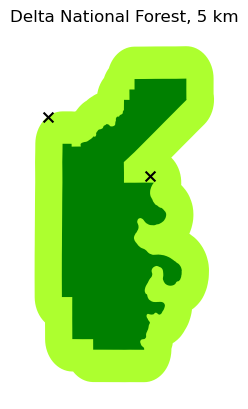

Deschutes National Forest


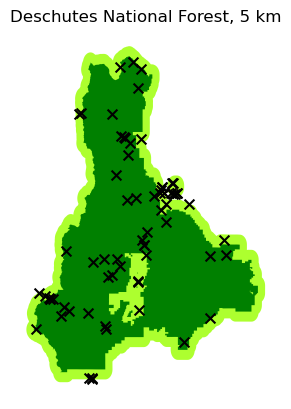

Dixie National Forest


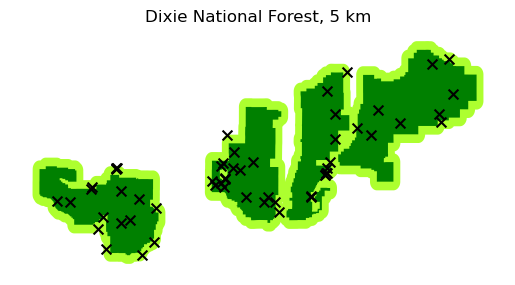

El Yunque National Forest


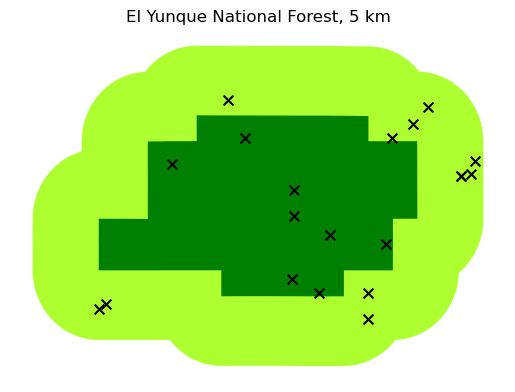

Eldorado National Forest


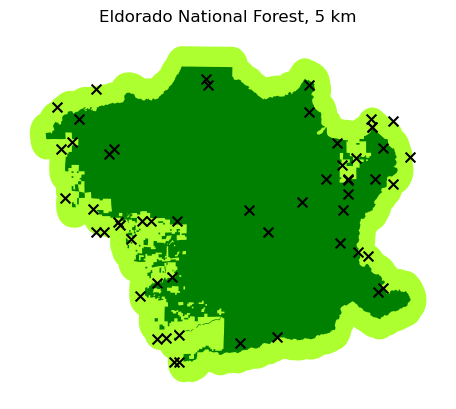

Finger Lakes National Forest


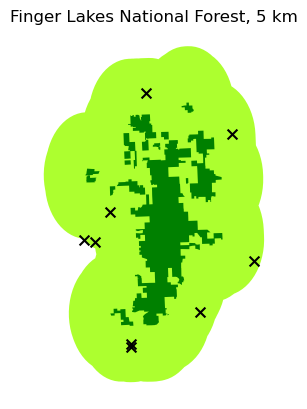

Fishlake National Forest


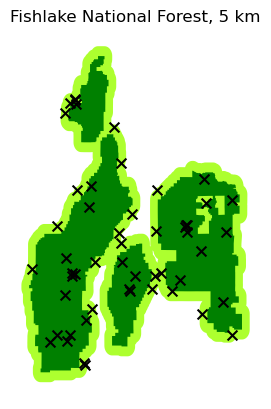

Flathead National Forest


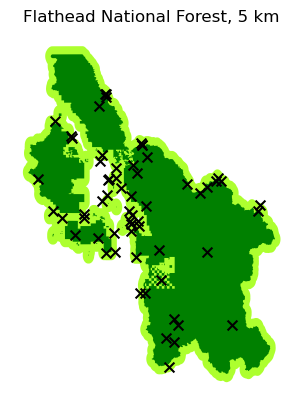

Francis Marion National Forest


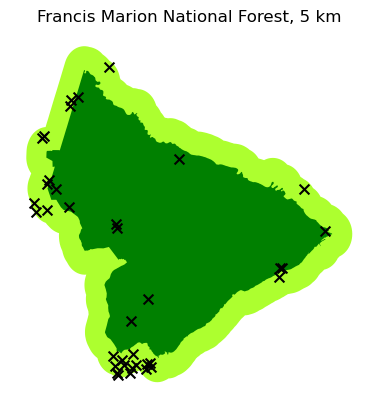

Fremont National Forest


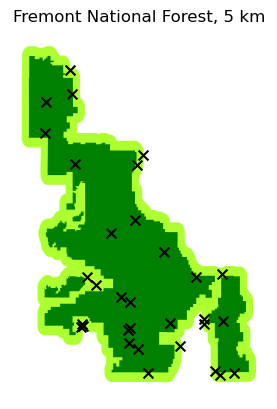

Gallatin National Forest


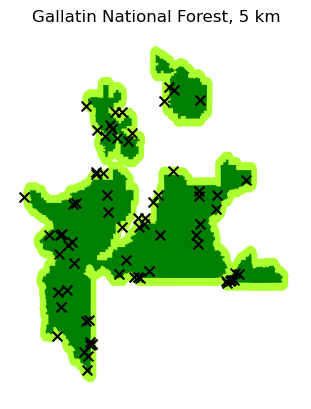

George Washington National Forest


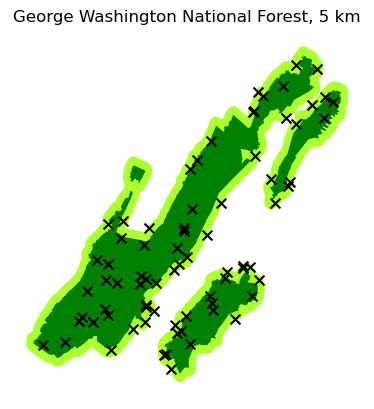

Gifford Pinchot National Forest


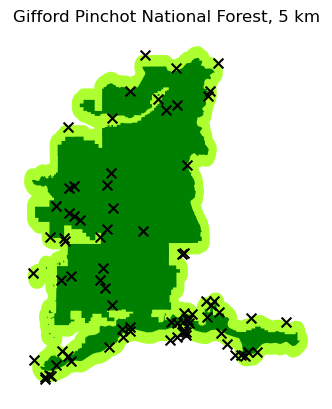

Gila National Forest


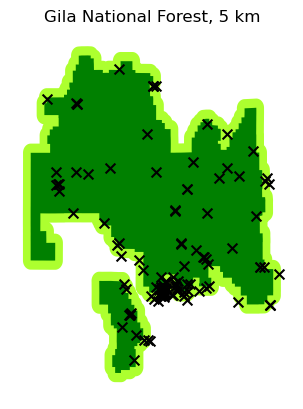

Grand Mesa National Forest


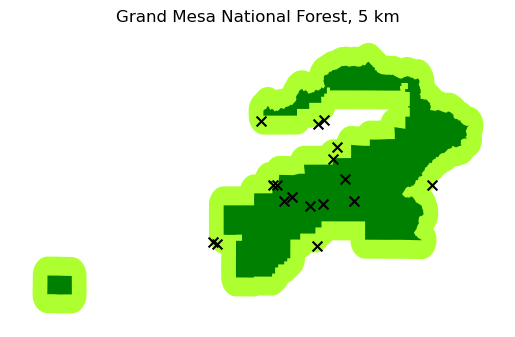

Green Mountain National Forest


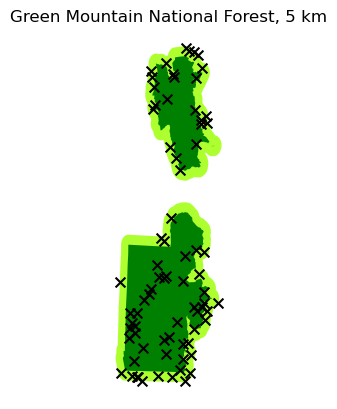

Gunnison National Forest


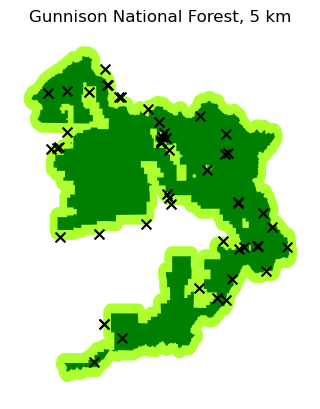

Helena National Forest


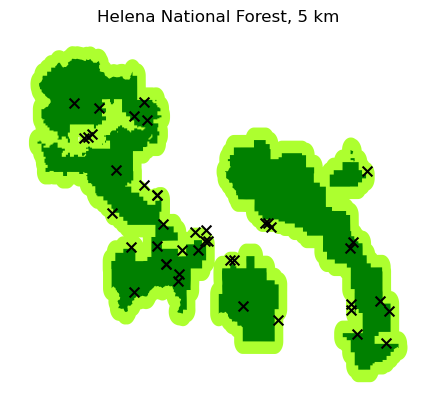

Hiawatha National Forest


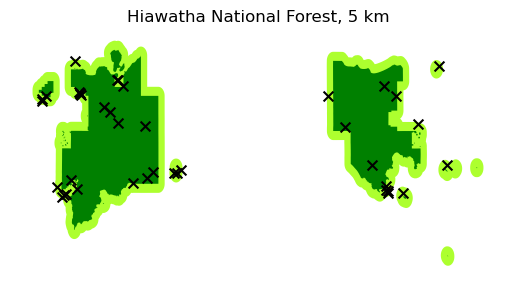

Holly Springs National Forest


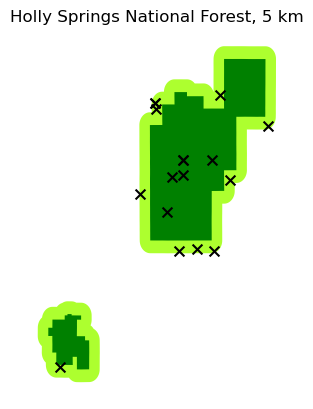

Homochitto National Forest


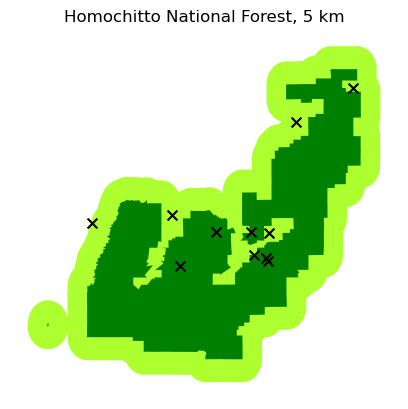

Hoosier National Forest


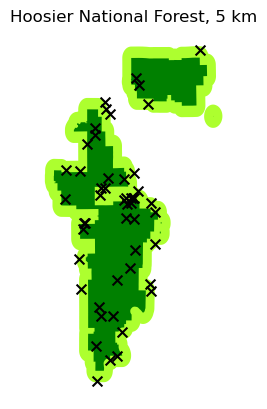

Humboldt National Forest


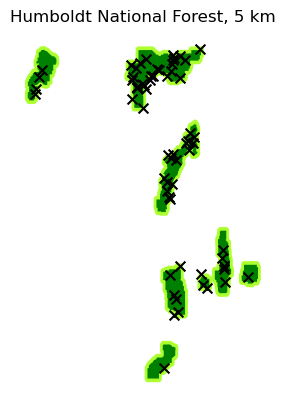

Huron National Forest


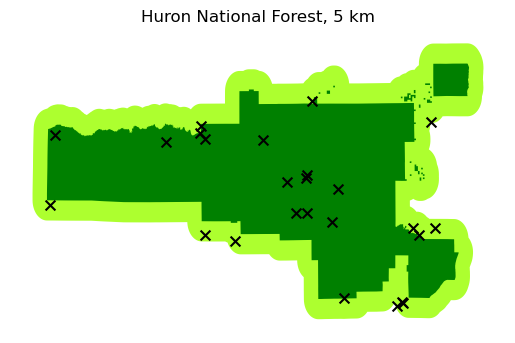

Inyo National Forest


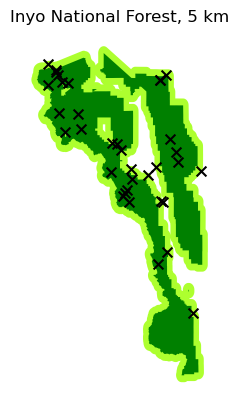

Jefferson National Forest


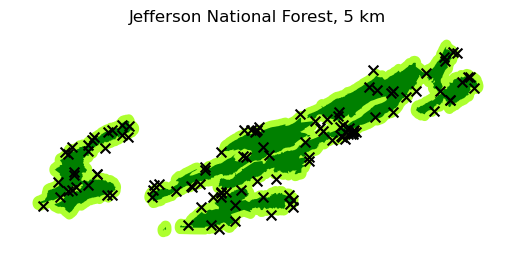

Kaibab National Forest


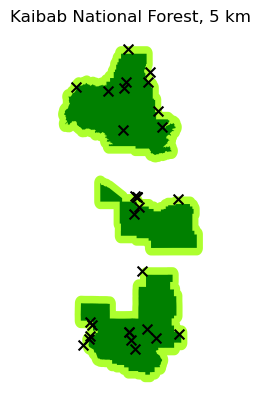

Kaniksu National Forest


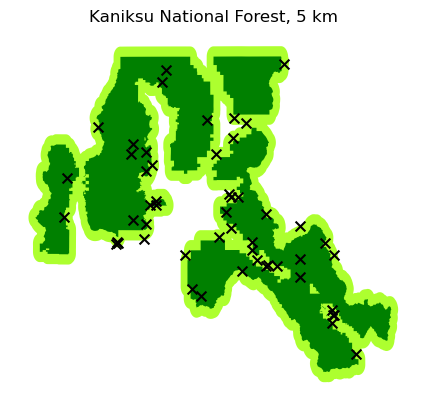

Kisatchie National Forest


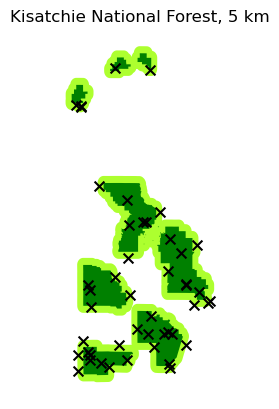

Klamath National Forest


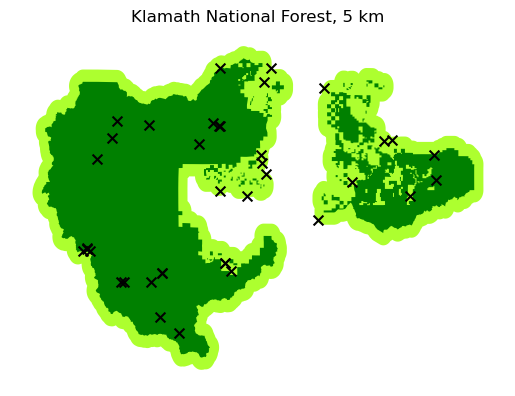

Kootenai National Forest


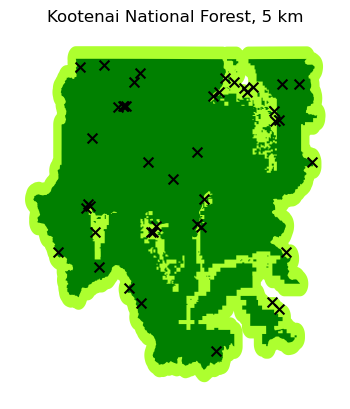

Lassen National Forest


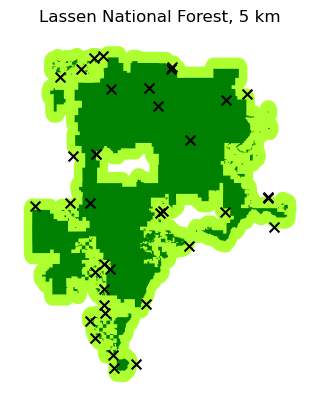

Lewis & Clark National Forest


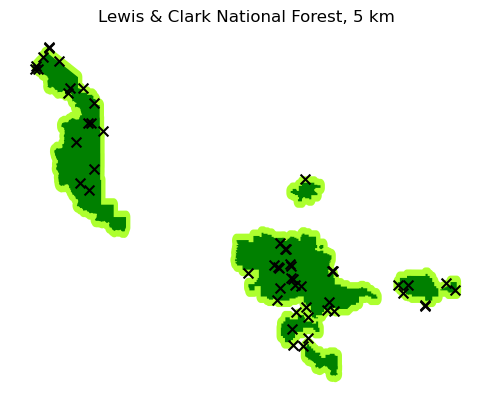

Lincoln National Forest


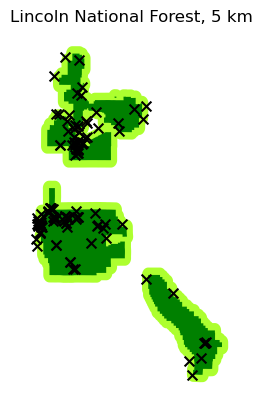

Lolo National Forest


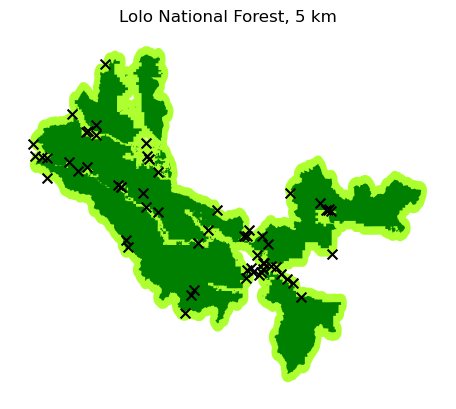

Los Padres National Forest


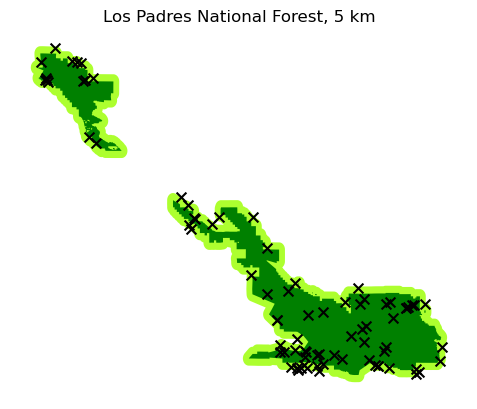

Malheur National Forest


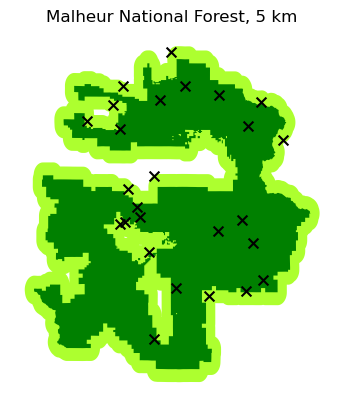

Manistee National Forest


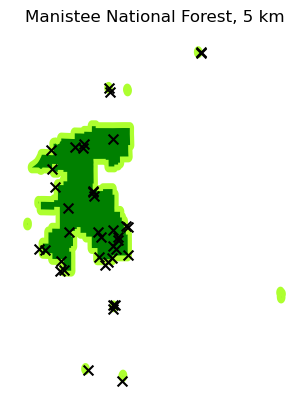

Manti-La Sal National Forest


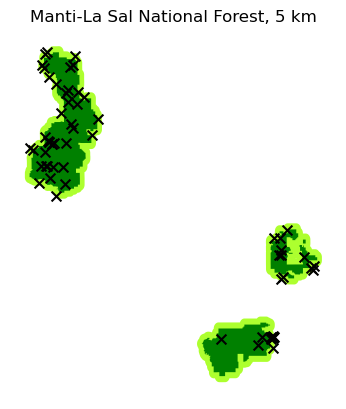

Mark Twain National Forest


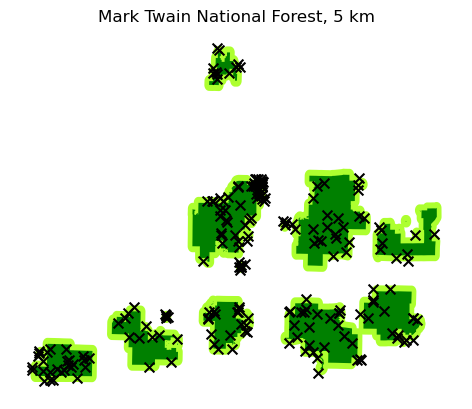

Medicine Bow National Forest


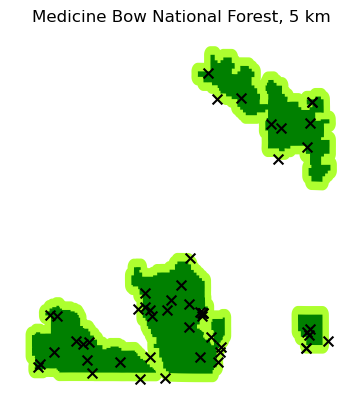

Mendocino National Forest


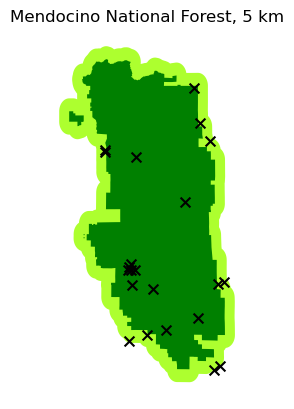

Modoc National Forest


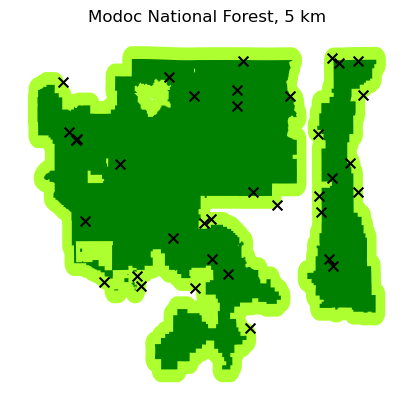

Monongahela National Forest


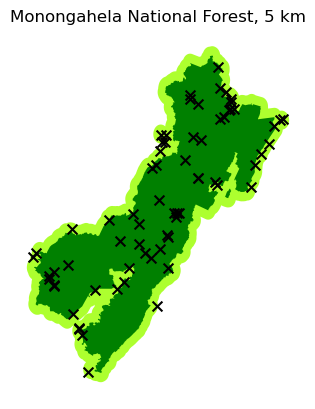

Mt. Baker National Forest


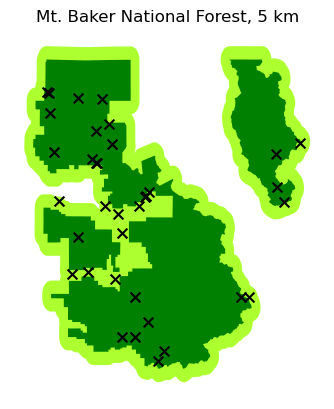

Mt. Hood National Forest


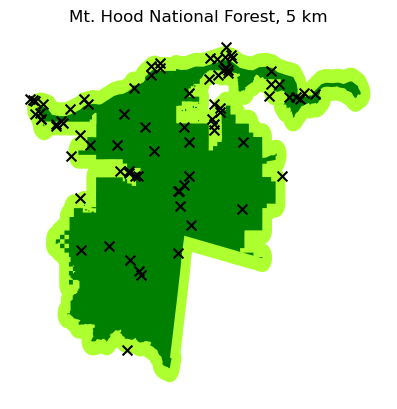

Nantahala National Forest


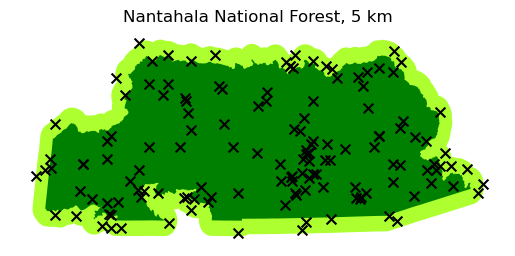

Nebraska National Forest


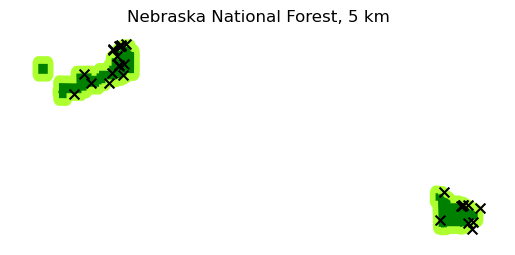

Nezperce National Forest


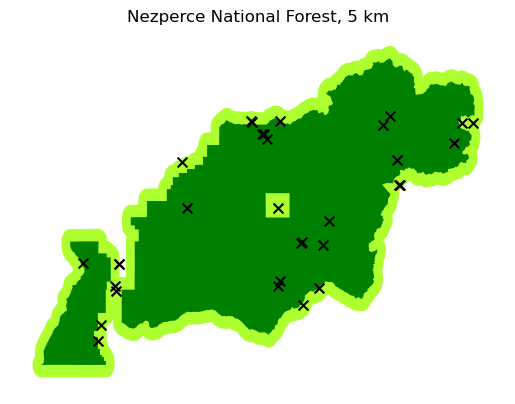

Nicolet National Forest


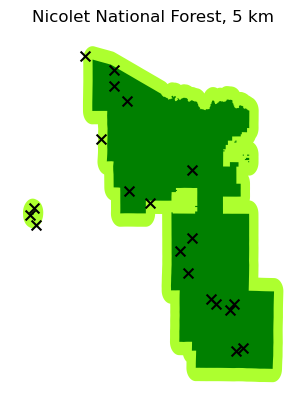

Ocala National Forest


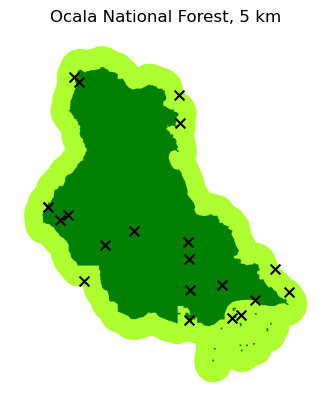

Ochoco National Forest


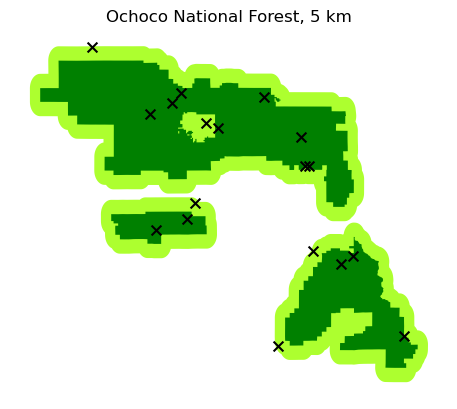

Oconee National Forest


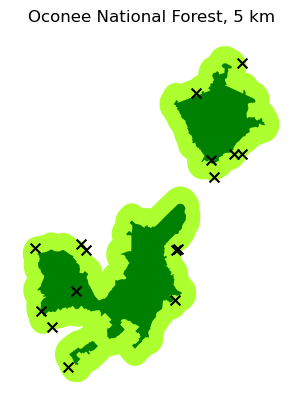

Okanogan National Forest


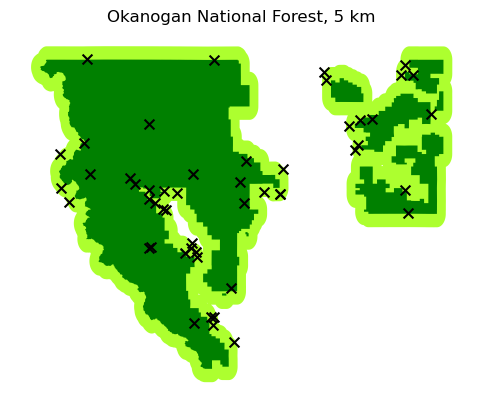

Olympic National Forest


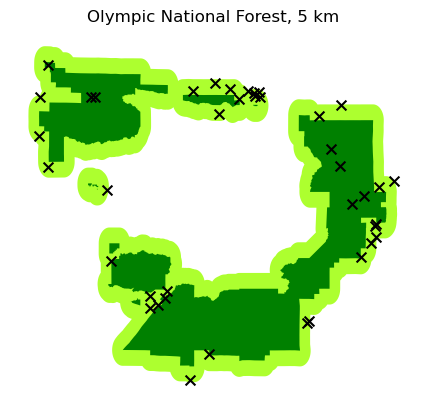

Osceola National Forest


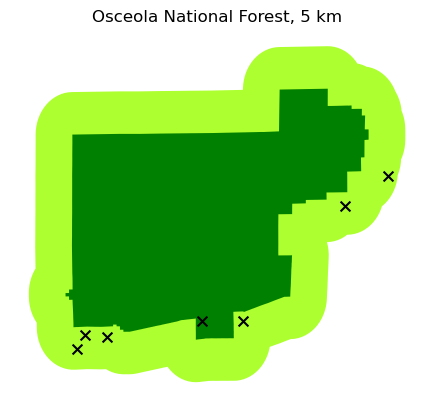

Ottawa National Forest


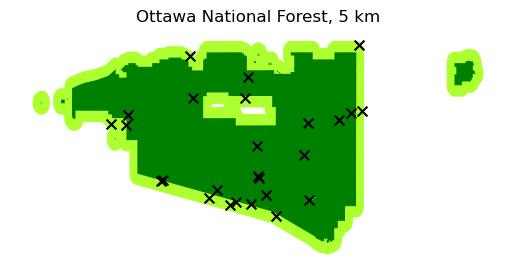

Ouachita National Forest


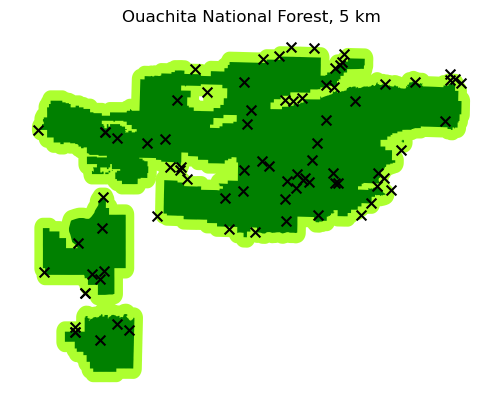

Ozark National Forest


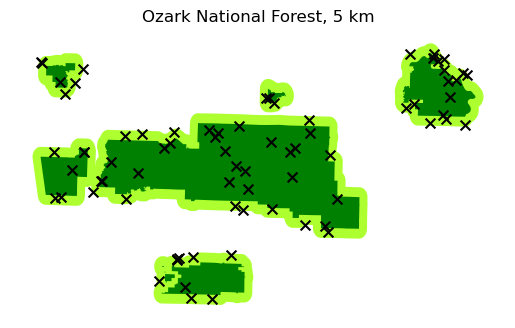

Payette National Forest


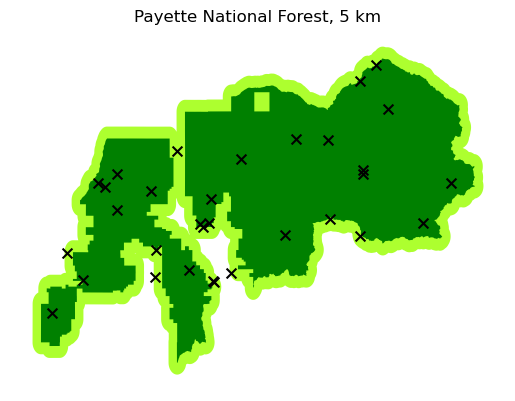

Pike National Forest


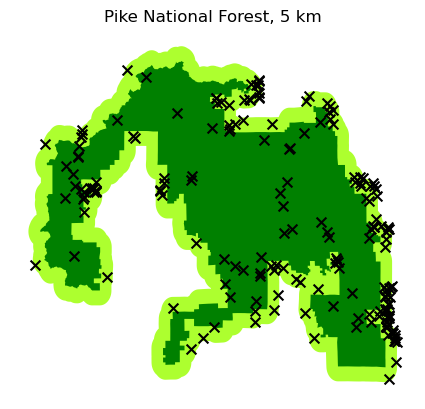

Pisgah National Forest


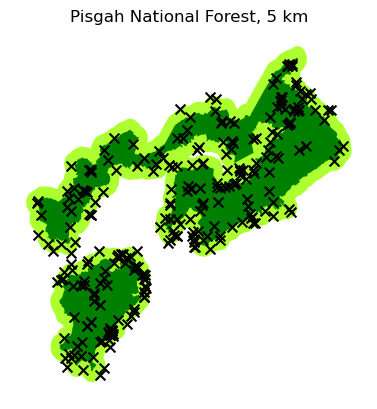

Plumas National Forest


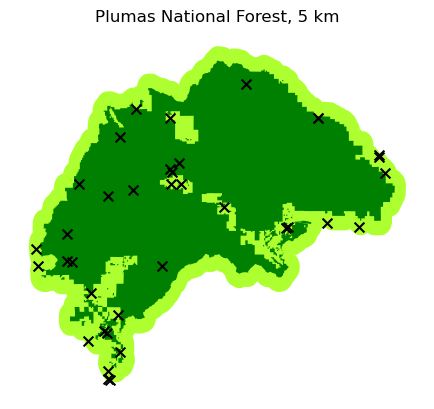

Prescott National Forest


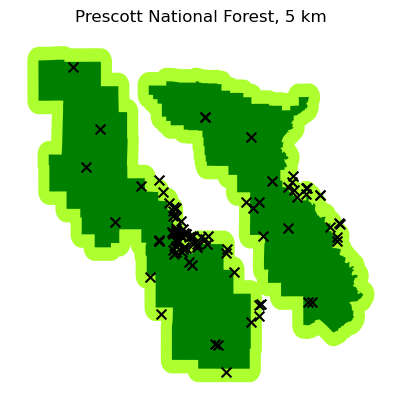

Rio Grande National Forest


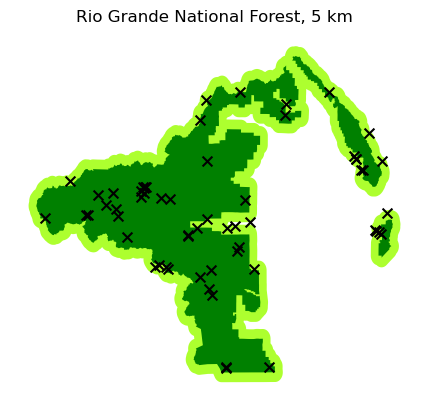

Rogue River National Forest


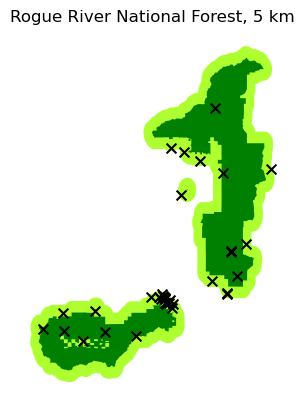

Roosevelt National Forest


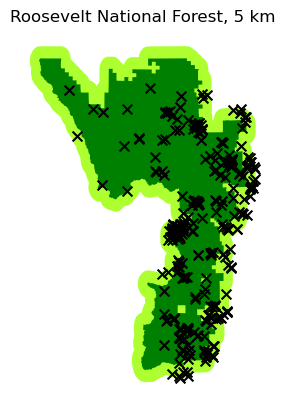

Routt National Forest


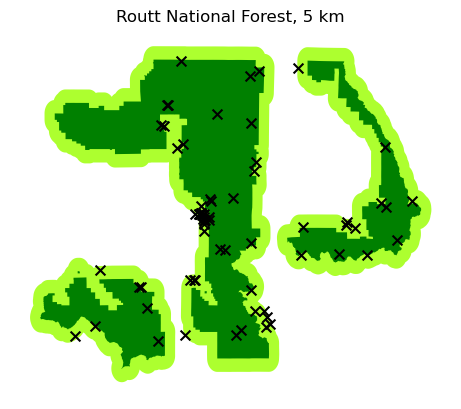

Sabine National Forest


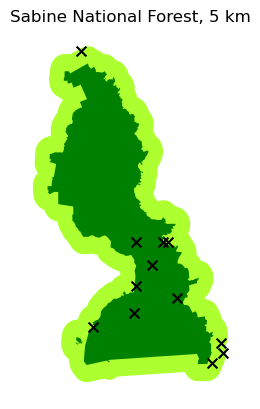

Salmon National Forest


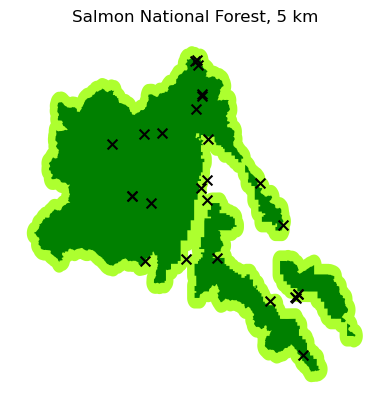

Sam Houston National Forest


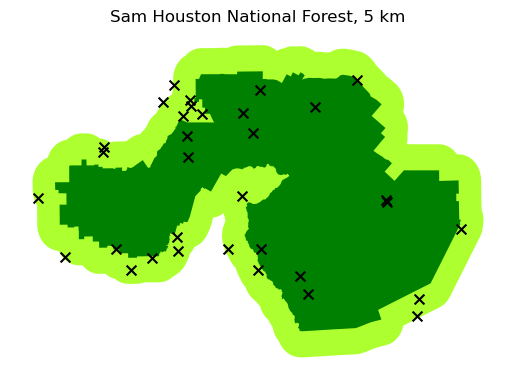

Samuel R. McKelvie National Forest


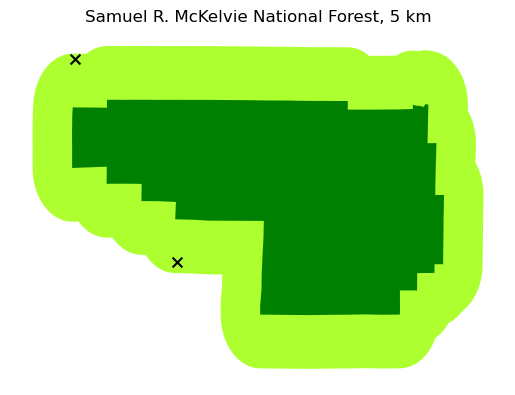

San Bernardino National Forest


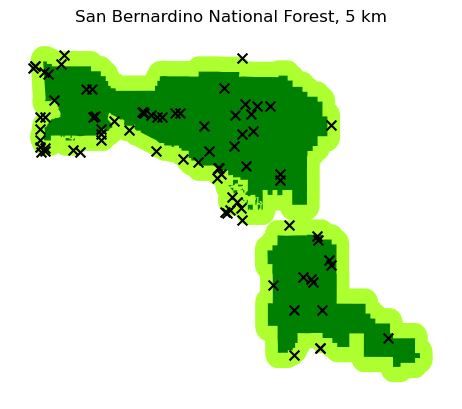

San Isabel National Forest


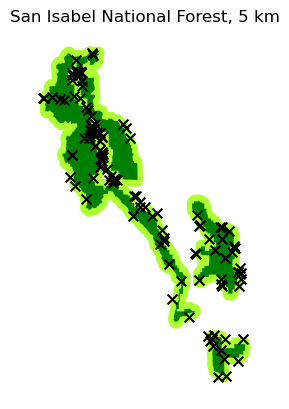

San Juan National Forest


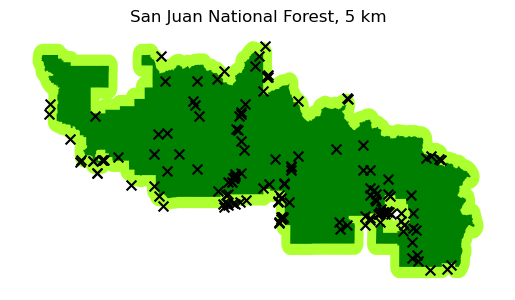

Santa Fe National Forest


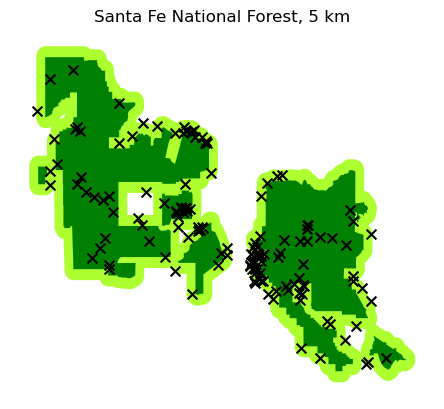

Sawtooth National Forest


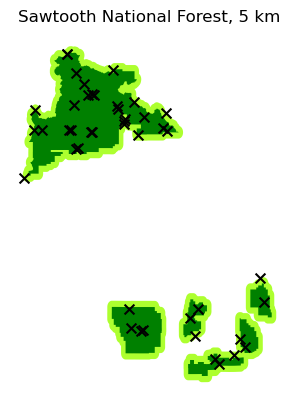

Sequoia National Forest


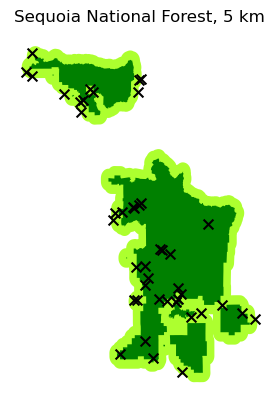

Shasta National Forest


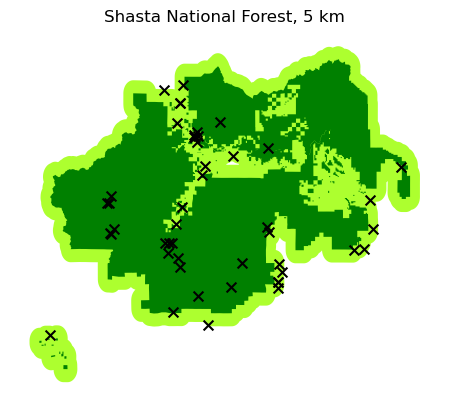

Shawnee National Forest


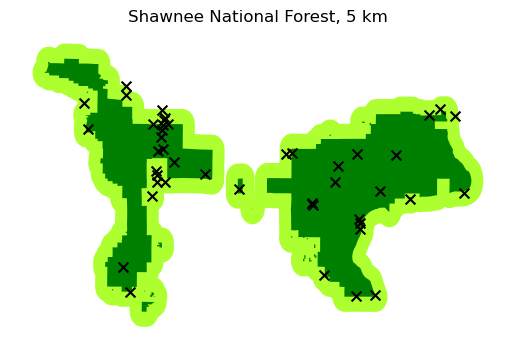

Shoshone National Forest


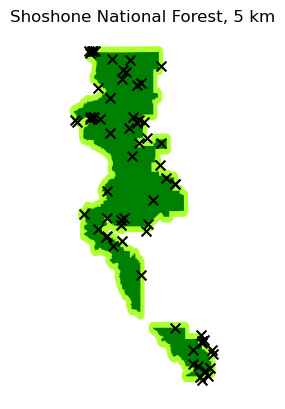

Sierra National Forest


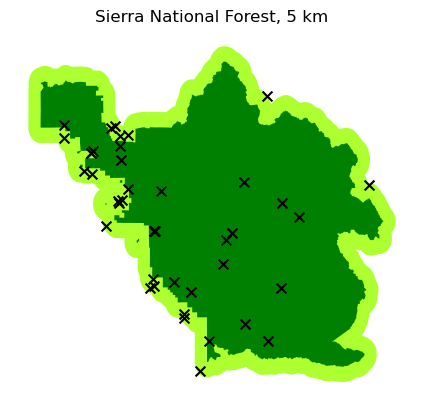

Siskiyou National Forest


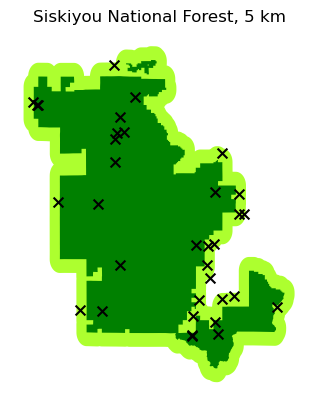

Sitgreaves National Forest


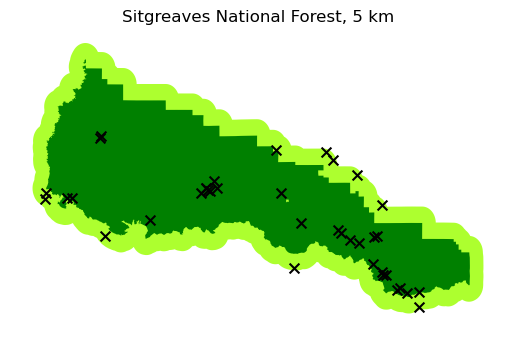

Siuslaw National Forest


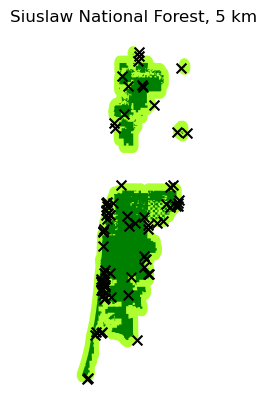

Six Rivers National Forest


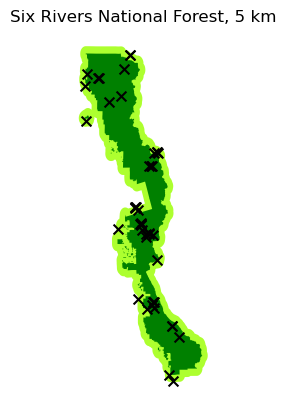

Snoqualmie National Forest


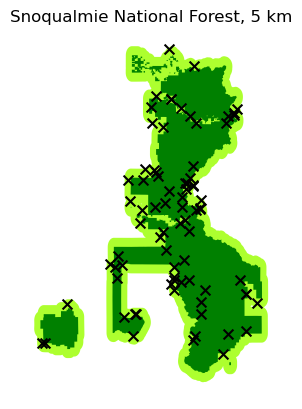

St. Francis National Forest


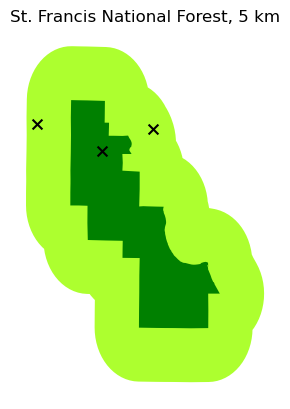

St. Joe National Forest


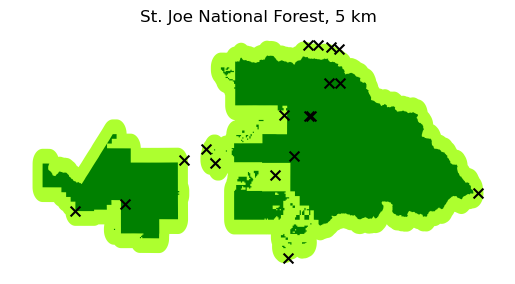

Stanislaus National Forest


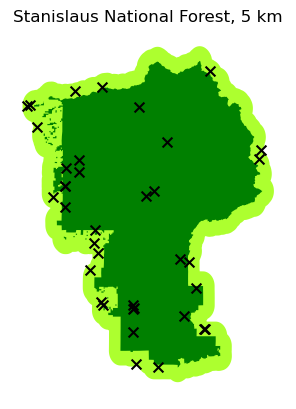

Sumter National Forest


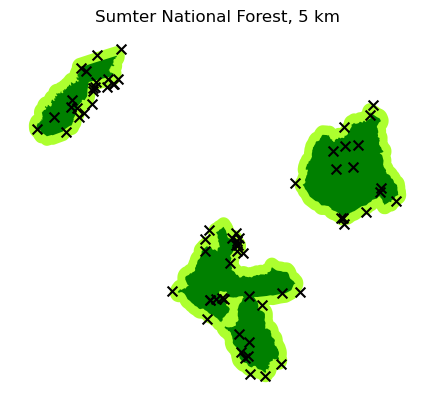

Superior National Forest


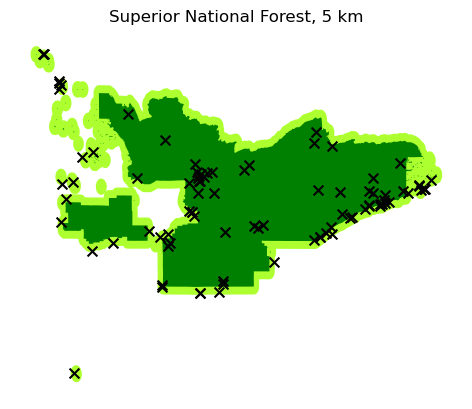

Tahoe National Forest


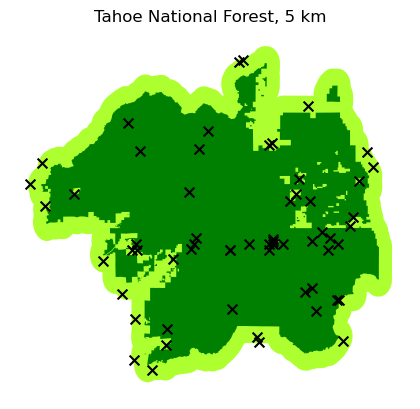

Talladega National Forest


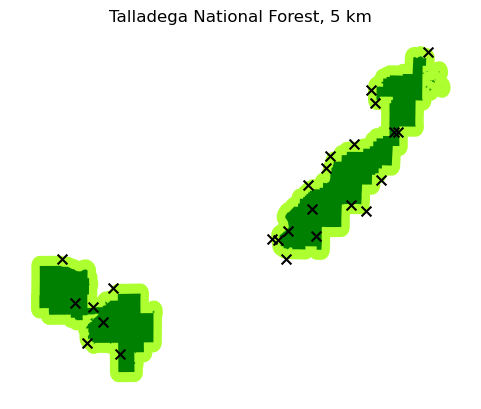

Targhee National Forest


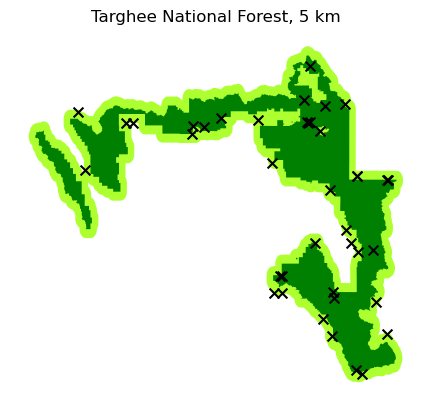

Teton National Forest


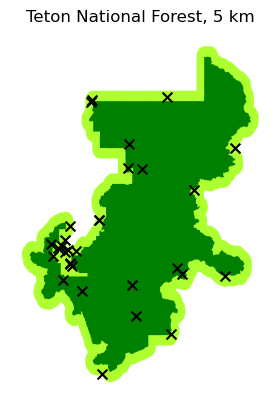

Toiyabe National Forest


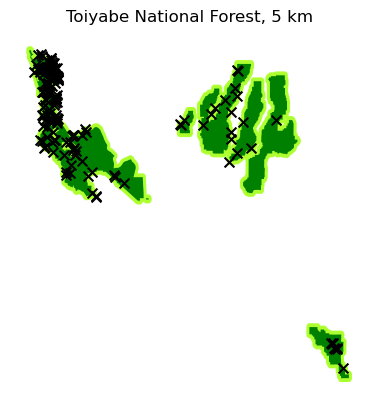

Tombigbee National Forest


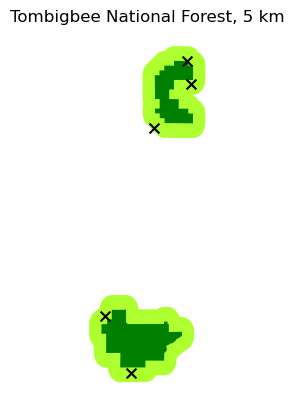

Tongass National Forest


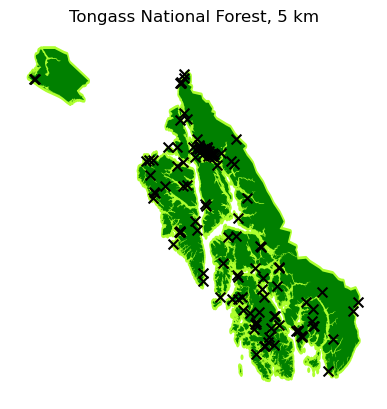

Tonto National Forest


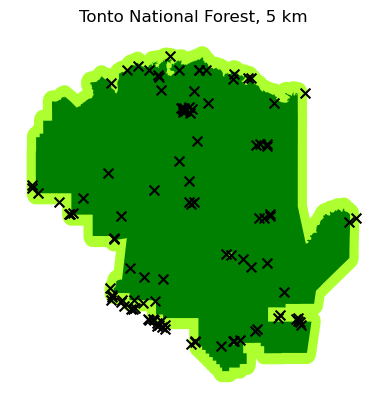

Trinity National Forest


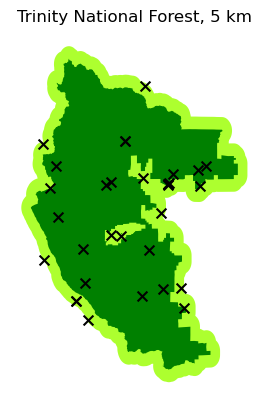

Tuskegee National Forest


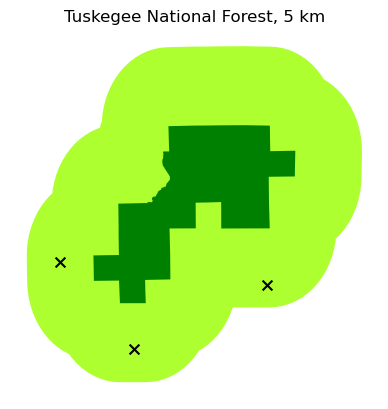

Uinta National Forest


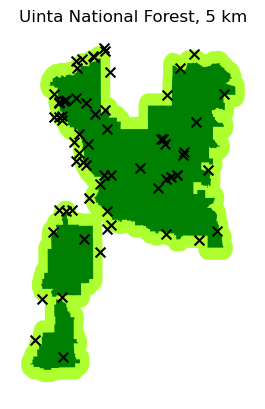

Umatilla National Forest


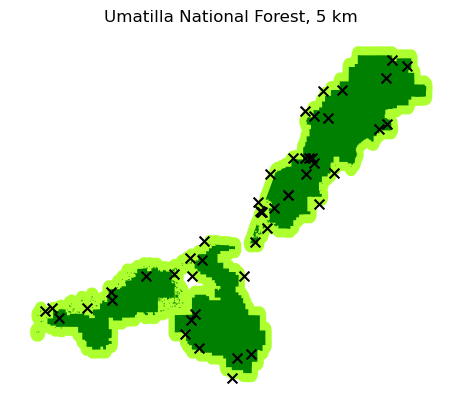

Umpqua National Forest


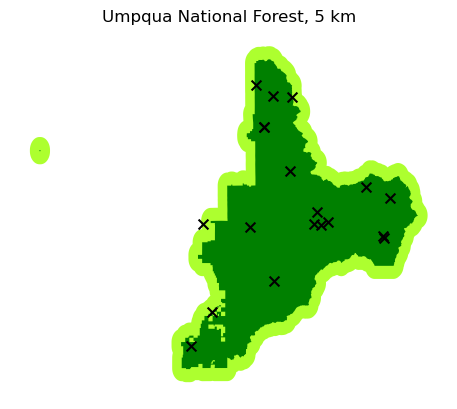

Uncompahgre National Forest


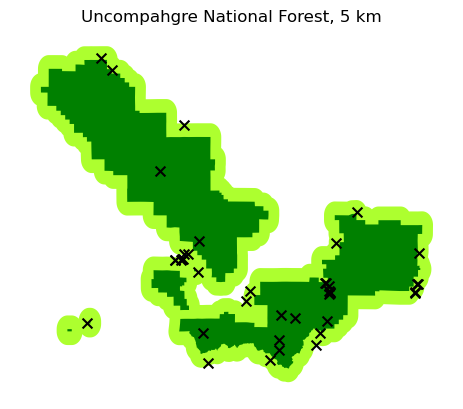

Uwharrie National Forest


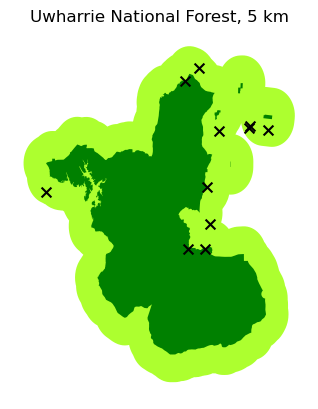

Wallowa National Forest


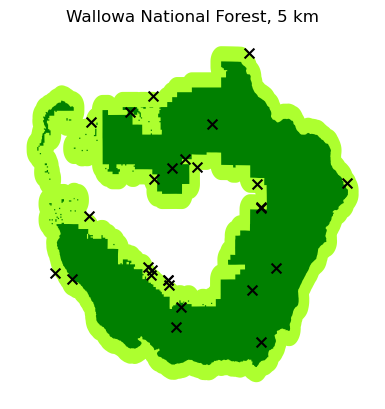

Wasatch National Forest


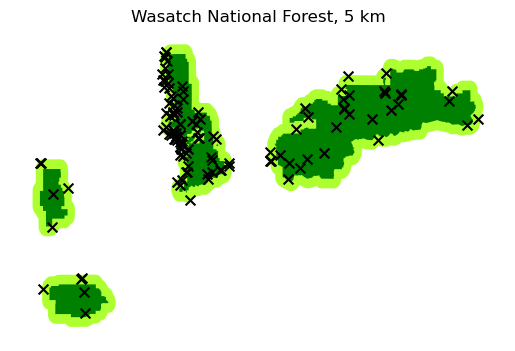

Wayne National Forest


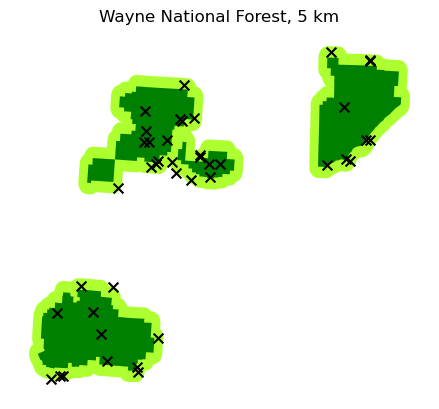

Wenatchee National Forest


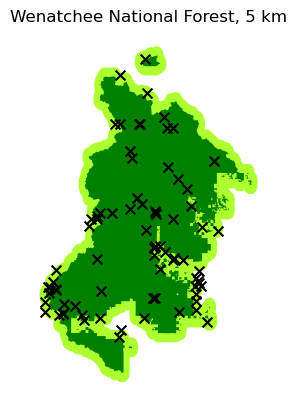

White Mountain National Forest


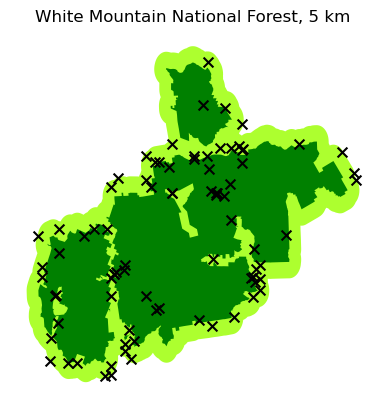

White River National Forest


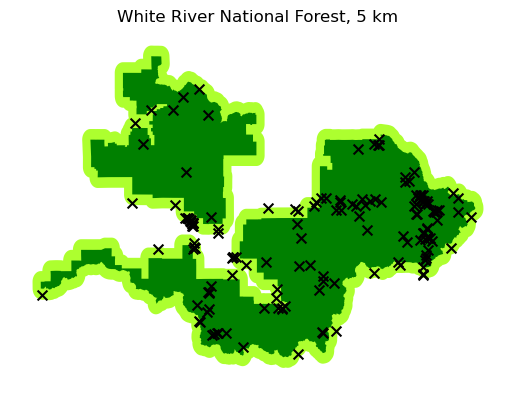

Whitman National Forest


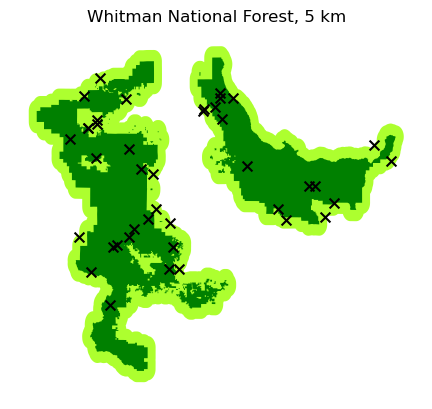

Willamette National Forest


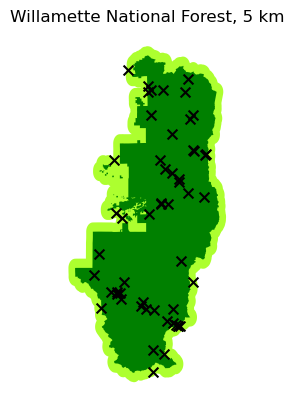

William B. Bankhead National Forest


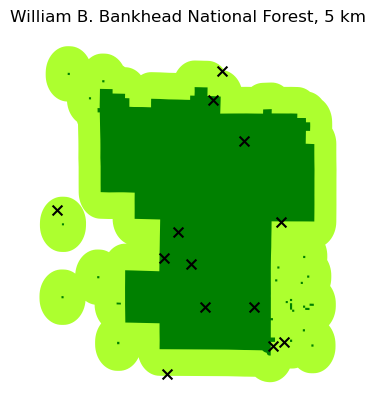

Winema National Forest


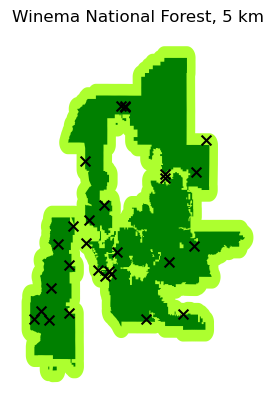

In [16]:
# Shapes plotting

def forest_plotting(forest):
    
    # forests polygone
    polygon_ori = gdf_forest.loc[gdf_forest['FORESTNAME']==f, 'geometry']
    polygon_ext = gdf_forest_ext.loc[gdf_forest_ext['FORESTNAME']==f, 'geometry']
    p = pd.concat([polygon_ext, polygon_ori])

    # stations point
    proc = gdf_forest.loc[gdf_forest['FORESTNAME']==f, 'PROCLAIMED'].to_string(index=False)
    stations = joined_gdf_ext.loc[joined_gdf_ext['PROCLAIMED']==proc, 'geometry']

    # plotting
    print(forest)
    if len(stations) != 0:
        base = p.plot(color=['greenyellow', 'green'])
        stations.plot(ax=base, marker='x', color='black', markersize=50)
        plt.title(f'{f}, {dist} km')
        plt.axis('off')
        plt.show()
    
forests_list = gdf_forest['FORESTNAME']
for f in forests_list:
    forest_plotting(f)

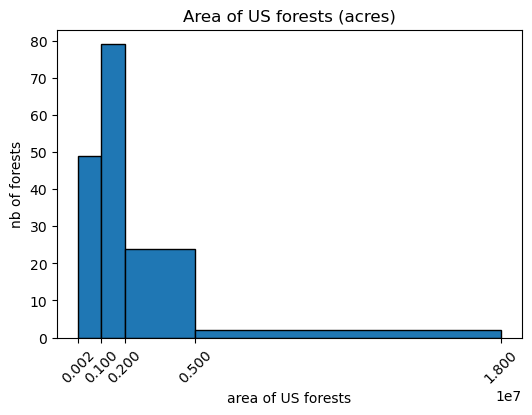

In [17]:
# plotting forests by area
plt.figure(figsize=(6,4))
plt.hist(gdf_forest['GIS_ACRES'], bins=[15000, 1000000, 2000000, 5000000, 18000000], edgecolor='k')
plt.xticks([15000, 1000000, 2000000, 5000000, 18000000], rotation=45)
plt.title('Area of US forests (acres)')
plt.xlabel('area of US forests')
plt.ylabel('nb of forests');

### import weather data

In [18]:
# paths list
files = [f'cloud-data/digitalrnd-projects-ireland/Vaccine/Research/Magellan/users/XLO/test/temp/{i}.csv.gz' for i in range(1992, 2016)]

In [20]:
# load and transform data
df_list = []
for f in files:
    print(f[-11:])
    df = pd.read_csv(f, compression='gzip', sep=',',
                     header=None,
                     names=['id_station', 'date', 'element', 'data_value', 'M-flag', 'Q-flag', 'S-flag', 'obs_time'],
                     )
    # redemove useless columns
    df = df.drop(columns=['M-flag', 'Q-flag', 'S-flag', 'obs_time'])
    # select US stations
    df = df.loc[(df['id_station'].str.startswith(('US', 'RQ')))]
    # select temperature values of interest
    df = df.loc[(df['element'] == 'TMAX') | (df['element'] == 'TMIN') | (df['element'] == 'TAVG') | (df['element'] == 'PRCP') | (df['element'] == 'AWND') | (df['element'] == 'AWDR')]
    # pivot table
    df_piv = pd.pivot_table(df, index=['id_station', 'date'], columns='element', values='data_value').reset_index()
    df_list.append(df_piv)

df_out = pd.concat(df_list, axis=0, ignore_index=True)
df_out.shape

1992.csv.gz
1993.csv.gz
1994.csv.gz
1995.csv.gz
1996.csv.gz
1997.csv.gz
1998.csv.gz
1999.csv.gz
2000.csv.gz
2001.csv.gz
2002.csv.gz
2003.csv.gz
2004.csv.gz
2005.csv.gz
2006.csv.gz
2007.csv.gz
2008.csv.gz
2009.csv.gz
2010.csv.gz
2011.csv.gz
2012.csv.gz
2013.csv.gz
2014.csv.gz
2015.csv.gz


(114965883, 8)

In [24]:
# merge weather data with forests
df_final = pd.merge(df_out, joined_gdf[['id_station', 'state', 'PROCLAIMED']], on='id_station')
df_final = df_final.loc[df_final['PROCLAIMED'].notnull()]
# conversion tenths of unit to unit
df_final[['TAVG', 'TMAX', 'TMIN', 'PRCP', 'AWND']] = df_final[['TAVG', 'TMAX', 'TMIN', 'PRCP', 'AWND']].apply(lambda x: x/10)
df_final

id_station      date  AWND  PRCP  TAVG  TMAX  TMIN  AWDR state  \
299240     RQC00666805  19920101   NaN   0.0   NaN   NaN   NaN   NaN    PR   
299241     RQC00666805  19920102   NaN   0.0   NaN   NaN   NaN   NaN    PR   
299242     RQC00666805  19920103   NaN   0.0   NaN   NaN   NaN   NaN    PR   
299243     RQC00666805  19920104   NaN   0.0   NaN   NaN   NaN   NaN    PR   
299244     RQC00666805  19920105   NaN  10.2   NaN   NaN   NaN   NaN    PR   
...                ...       ...   ...   ...   ...   ...   ...   ...   ...   
114959526  US1WYSL0013  20151219   NaN   0.0   NaN   NaN   NaN   NaN    WY   
114959527  US1WYSL0013  20151220   NaN   1.5   NaN   NaN   NaN   NaN    WY   
114959528  US1WYSL0013  20151221   NaN   1.5   NaN   NaN   NaN   NaN    WY   
114959529  US1WYSL0013  20151223   NaN   4.1   NaN   NaN   NaN   NaN    WY   
114959530  US1WYSL0013  20151224   NaN   3.6   NaN   NaN   NaN   NaN    WY   

             PROCLAIMED  
299240     295434010328  
299241     295434010328  
299242     295434010328  
299243     295434010328  
299244     295434010328  
...                 ...  
114959526  295439010328  
114959527  295439010328  
114959528  295439010328  
114959529  295439010328  
114959530  295439010328  

[12083563 rows x 10 columns]

In [25]:
# aggregation of weather date by US forest and day
df_grouped = df_final.groupby(by=['PROCLAIMED', 'date']) \
                    .agg({'TAVG':'mean', 'TMAX':'mean', 'TMIN':'mean', 'PRCP':'mean', 'AWND':'mean', 'AWDR':'mean'}) \
                    .rename(columns={'TAVG':'TAVG_mean', 'TMAX':'TMAX_mean', 'TMIN':'TMIN_mean', 'PRCP':'PRCP_mean', 'AWND':'WSPD_mean', 'AWDR':'WDIR_mean'}) \
                    .reset_index()
                    #.agg({'TAVG':['mean', 'size'], 'TMAX':['mean', 'size'], 'TMIN':['mean', 'size']}) \
                    #.rename(columns={('TAVG','mean'):'TAVG_mean'}) \

df_grouped = df_grouped.astype({'date':'str'})
df_grouped['date'] = pd.to_datetime(df_grouped['date'], format='%Y%m%d')
df_grouped

PROCLAIMED       date  TAVG_mean  TMAX_mean  TMIN_mean  PRCP_mean  \
0        105935010328 1992-01-01      -5.50   4.766667 -11.533333   0.000000   
1        105935010328 1992-01-02      -4.45   5.133333 -10.366667   0.000000   
2        105935010328 1992-01-03      -4.25   2.433333  -9.000000  10.400000   
3        105935010328 1992-01-04       0.05   5.866667  -3.200000   4.950000   
4        105935010328 1992-01-05       0.75   3.300000  -1.200000   9.400000   
...               ...        ...        ...        ...        ...        ...   
1263179   96813010328 2015-12-27     -11.99  -2.036364 -18.200000   0.500000   
1263180   96813010328 2015-12-28      -9.42  -2.727273 -14.718182   0.750000   
1263181   96813010328 2015-12-29     -11.84  -6.981818 -14.718182   0.530000   
1263182   96813010328 2015-12-30     -11.44  -5.818182 -15.809091   1.260000   
1263183   96813010328 2015-12-31     -13.94  -7.600000 -18.920000   0.277778   

         WSPD_mean  WDIR_mean  
0              NaN        NaN  
1              NaN        NaN  
2              NaN        NaN  
3              NaN        NaN  
4              NaN        NaN  
...            ...        ...  
1263179        0.7      190.0  
1263180        0.7      200.0  
1263181        0.9      281.0  
1263182        1.0      277.0  
1263183        1.0      240.0  

[1263184 rows x 8 columns]

In [26]:
# rolling average data
df_grouped['TMAX_mean_10D'] = df_grouped['TMAX_mean'].rolling(10).mean()
df_grouped['TMAX_mean_30D'] = df_grouped['TMAX_mean'].rolling(30).mean()
df_grouped['TAVG_mean_10D'] = df_grouped['TAVG_mean'].rolling(10).mean()
df_grouped['TAVG_mean_30D'] = df_grouped['TAVG_mean'].rolling(30).mean()
df_grouped['PRCP_mean_10D'] = df_grouped['PRCP_mean'].rolling(10).mean()
df_grouped['PRCP_mean_30D'] = df_grouped['PRCP_mean'].rolling(30).mean()
df_grouped


PROCLAIMED       date  TAVG_mean  TMAX_mean  TMIN_mean  PRCP_mean  \
0        105935010328 1992-01-01      -5.50   4.766667 -11.533333   0.000000   
1        105935010328 1992-01-02      -4.45   5.133333 -10.366667   0.000000   
2        105935010328 1992-01-03      -4.25   2.433333  -9.000000  10.400000   
3        105935010328 1992-01-04       0.05   5.866667  -3.200000   4.950000   
4        105935010328 1992-01-05       0.75   3.300000  -1.200000   9.400000   
...               ...        ...        ...        ...        ...        ...   
1263179   96813010328 2015-12-27     -11.99  -2.036364 -18.200000   0.500000   
1263180   96813010328 2015-12-28      -9.42  -2.727273 -14.718182   0.750000   
1263181   96813010328 2015-12-29     -11.84  -6.981818 -14.718182   0.530000   
1263182   96813010328 2015-12-30     -11.44  -5.818182 -15.809091   1.260000   
1263183   96813010328 2015-12-31     -13.94  -7.600000 -18.920000   0.277778   

         WSPD_mean  WDIR_mean  TMAX_mean_10D  TMAX_mean_30D  TAVG_mean_10D  \
0              NaN        NaN            NaN            NaN            NaN   
1              NaN        NaN            NaN            NaN            NaN   
2              NaN        NaN            NaN            NaN            NaN   
3              NaN        NaN            NaN            NaN            NaN   
4              NaN        NaN            NaN            NaN            NaN   
...            ...        ...            ...            ...            ...   
1263179        0.7      190.0      -1.370000       0.609697         -6.478   
1263180        0.7      200.0      -2.165455       0.670121         -7.201   
1263181        0.9      281.0      -3.260909       0.627727         -8.207   
1263182        1.0      277.0      -3.843636       0.578788         -9.058   
1263183        1.0      240.0      -4.561818       0.341515        -10.196   

         TAVG_mean_30D  PRCP_mean_10D  PRCP_mean_30D  
0                  NaN            NaN            NaN  
1                  NaN            NaN            NaN  
2                  NaN            NaN            NaN  
3                  NaN            NaN            NaN  
4                  NaN            NaN            NaN  
...                ...            ...            ...  
1263179      -4.777000       7.621000       3.840852  
1263180      -4.768000       7.696000       3.781407  
1263181      -4.828667       7.580000       3.761667  
1263182      -4.867000       6.713000       3.803667  
1263183      -5.069000       4.721778       3.787926  

[1263184 rows x 14 columns]

In [27]:
# export weather data
out_path = 'cloud-data/digitalrnd-projects-ireland/Vaccine/Research/Magellan/users/XLO/test/temp/weather_data_forest.csv.gz'
df_grouped.to_csv(out_path, compression='gzip')

print('file_ok')


file_ok
